In [200]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.optim
# CODE FILES HERE
from examples.vae.vae import Encoder, Decoder, Vae, PATH
from solver import Solver
from dataloader import DataLoader
from plot import plot_gallery

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [226]:
# 2 layer networks for encoder and decoder
learning_rate = 1e-3
batch_size = 128
optimizer = torch.optim.Adam
num_normal_plots = 2

In [231]:
dataset = "LFW"

input_dim = 0
hidden_dim = 0
z_dim = 0
if dataset == "MNIST" or dataset == "EMNIST":
    epochs = 6 #0000
    h = 28
    w = 28
    img_dims = (h, w)
    input_dim = np.prod((h, w))
    hidden_dim = 500 # Kingma, Welling use 500 neurons, otherwise use 400
    z_dim = 20 # 1000 is suggested in the paper "Tutorial on VAE" but Kingma, Welling show 20 is sufficient for MNIST
elif dataset == "LFW":
    epochs = 1000
    h = 50
    w = 37
    input_dim = np.prod((h, w))
    hidden_dim = 200 # as in Kingma for Frey Face
    z_dim = 2

In [232]:
encoder = Encoder(input_dim, hidden_dim, z_dim)
decoder = Decoder(z_dim, hidden_dim, input_dim)
model = Vae(encoder, decoder)

In [ ]:
data_loader = DataLoader(PATH, batch_size, dataset, z_dim)
solver = Solver(model, data_loader, optimizer, z_dim, (h, w), epochs, num_normal_plots, batch_size, learning_rate)
solver.run()

Total dataset size:
n_samples: 13233
n_features: 1850
n_classes: 5749
img dims x: 50 y: 37
torch.Size([10586, 1, 50, 37]) torch.Size([10586])
+++++ START RUN +++++
====> Epoch: 1 train set loss avg: 1250.7780
====> Test set loss avg: 1247.3695
5.946296453475952 seconds for epoch 1
====> Epoch: 2 train set loss avg: 1235.3073
====> Test set loss avg: 1244.9336
6.763668537139893 seconds for epoch 2
====> Epoch: 3 train set loss avg: 1232.0740
====> Test set loss avg: 1241.9191
8.366065263748169 seconds for epoch 3
====> Epoch: 4 train set loss avg: 1228.3048
====> Test set loss avg: 1243.0165
6.7259521484375 seconds for epoch 4
====> Epoch: 5 train set loss avg: 1226.1422
====> Test set loss avg: 1243.1941
6.701603174209595 seconds for epoch 5
====> Epoch: 6 train set loss avg: 1225.0207
====> Test set loss avg: 1243.1359
6.588885545730591 seconds for epoch 6
====> Epoch: 7 train set loss avg: 1224.4307
====> Test set loss avg: 1244.6877
6.965364217758179 seconds for epoch 7
====> Epoch:

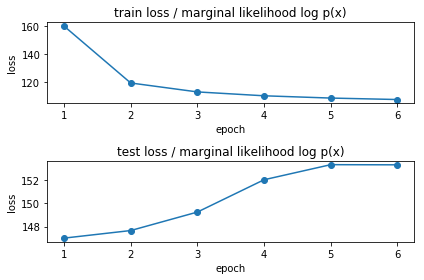

In [8]:
# Plotting train and test losses for all epochs
xaxis = np.arange(1, epochs+1)
train_losses = list(list(zip(*solver.train_loss_history))[1])
# Plotting the train loss
plt.subplot(2, 1, 1)
plt.plot(np.arange(1, len(solver.train_loss_history)+1), train_losses, '-o')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("train loss / marginal likelihood log p(x)")
#plt.legend(['train loss'], loc='upper right')
plt.xticks(xaxis)

# Plotting the test loss
plt.subplot(2, 1, 2)
plt.plot(np.arange(1, len(solver.test_loss_history)+1), solver.test_loss_history, '-o')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("test loss / marginal likelihood log p(x)")
#plt.legend(['test loss'], loc='upper right')
plt.xticks(xaxis)

plt.tight_layout()
plt.show()

epoch: 3, mu(z): -0.0032660895168349006, stddev(z): 1.0835758719617115, var(z): 1.1741366702975833, var(\mu(z)): 0.00012553219858091325
epoch: 6, mu(z): 0.0005852110150430272, stddev(z): 1.0400605122926139, var(z): 1.0817258692303744, var(\mu(z)): 0.00010972135351039469


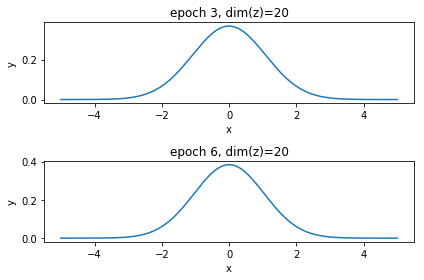

In [9]:
# Plotting histogram of the latent space, given the computed \mu and \sigma
# TODO: Compute the Var(\mu(z))
x = np.linspace(-5, 5, 5000)
plot_cols = np.arange(1, num_normal_plots+1)
for idx, stats in enumerate(solver.z_stats):
    epoch, mu, std, muz = stats
    print("epoch: {}, mu(z): {}, stddev(z): {}, var(z): {}, var(\mu(z)): {}".format(\
        epoch, mu, std, np.power(std, 2), torch.var(muz).item()))
    y = (1 / (np.sqrt(2 * np.pi * np.power(std, 2)))) * \
        (np.power(np.e, -(np.power((x - mu), 2) / (2 * np.power(std, 2)))))
    plt.subplot(2, 1, plot_cols[idx])
    plt.plot(x, y)
    plt.title("epoch {}, dim(z)={}".format(epoch, z_dim))
    plt.xlabel("x")
    plt.ylabel("y")

plt.tight_layout()
plt.show()

epoch: 1, train_loss: 160.14348, test_loss: 147.00365, recon. loss: 144.32104, KL div.: 15.82243
overfitting: 13.13982
epoch: 2, train_loss: 119.62167, test_loss: 147.65700, recon. loss: 96.92160, KL div.: 22.70002
overfitting: 28.03533
epoch: 3, train_loss: 113.25466, test_loss: 149.24990, recon. loss: 88.98756, KL div.: 24.26712
overfitting: 35.99524
epoch: 4, train_loss: 110.49759, test_loss: 152.03590, recon. loss: 85.70016, KL div.: 24.79745
overfitting: 41.53831
epoch: 5, train_loss: 108.87545, test_loss: 153.33546, recon. loss: 83.82892, KL div.: 25.04654
overfitting: 44.46001
epoch: 6, train_loss: 107.83446, test_loss: 153.32295, recon. loss: 82.60287, KL div.: 25.23160
overfitting: 45.48850


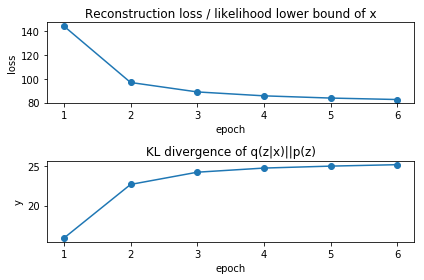

In [17]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
rls = list(list(zip(*solver.train_loss_history))[2])
kls = list(list(zip(*solver.train_loss_history))[3])
for ((epoch, train_loss, rl, kl), test_loss) in zip(solver.train_loss_history, solver.test_loss_history):
    print("epoch: {}, train_loss: {:.5f}, test_loss: {:.5f}, recon. loss: {:.5f}, KL div.: {:.5f}".format(epoch, train_loss, test_loss, rl, kl))
    print("overfitting: {:.5f}".format(abs(test_loss-train_loss)))

plt.subplot(2, 1, 1)
plt.plot(np.arange(1, len(rls)+1), rls, '-o')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Reconstruction loss / likelihood lower bound of x")
#plt.legend(['recon. loss'], loc='upper right')
plt.xticks(xaxis)

plt.subplot(2, 1, 2)
plt.plot(np.arange(1, len(kls)+1), kls, '-o')
plt.xlabel("epoch")
plt.ylabel("y")
plt.title("KL divergence of q(z|x)||p(z)")
#plt.legend(['KL div.'], loc='upper right')
plt.xticks(xaxis)

plt.tight_layout()
plt.show()

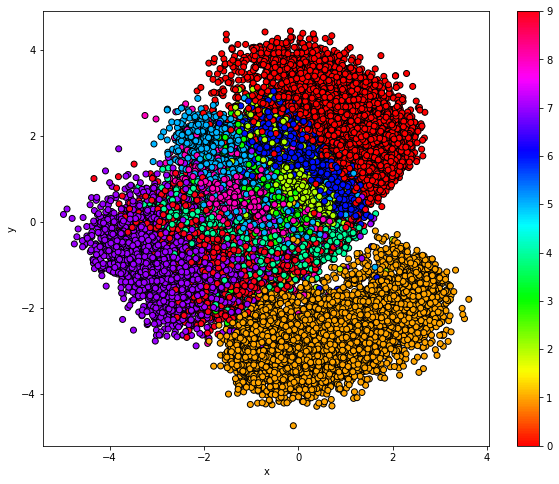

In [14]:
# visualize q(z|x) (latent space z)
if solver.z_dim == 2 and dataset == "MNIST":
    labels = solver.labels.tolist()
    plt.figure(figsize=(10,8))
    plt.scatter(solver.latent_space[:,0], solver.latent_space[:,1], c=labels, edgecolors='black', cmap='hsv')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar() # show color scale
else:
    print("Plot of latent space not possible as dimension of z is not 2")

[[ 71.        78.333336  47.666668 ... 187.66667   80.666664  11.      ]
 [215.       214.66667  217.33333  ... 145.       137.       126.      ]
 [110.       119.666664 120.666664 ... 249.33333  251.33333  250.      ]
 ...
 [142.33333  133.33333  133.66667  ... 116.       118.       151.33333 ]
 [111.333336 115.666664 152.66667  ...  54.333332  49.666668  56.      ]
 [ 11.333333  13.666667  16.333334 ... 165.33333  182.       209.      ]]


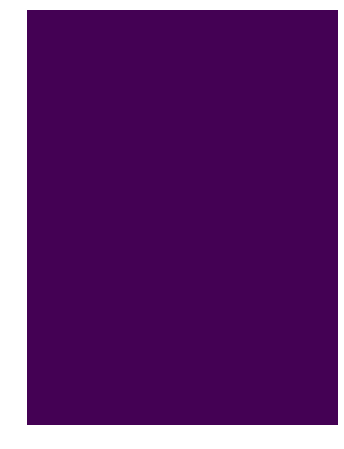

In [198]:
# LFW plots
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
data_folder_prefix = "../data/"
lfw = fetch_lfw_people(data_home=data_folder_prefix+"/LFW", min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw['images'].shape # c 
X = lfw['data']
n_features = X.shape[1]
y = lfw['target']
target_names = lfw['target_names']
n_classes = target_names.shape[0]     
train_set, test_set, y_train, y_test = train_test_split(
                X, y, test_size=0.20, random_state=42) # TODO remove later random state

plot_gallery(train_set/255.0, (h, w))